In [2]:
import pandas as pd
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

# Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")



In [3]:

# Load the merged dataset
df = pd.read_csv('cleaned_pfas_cancer_merged.csv')

# Display the first few rows to get a sense of the structure
print(df.head())

# Show all column names (features)
print("\nAvailable Features:")
print(df.columns.tolist())

# Optionally: check for missing values
print("\nMissing values per column:")
print(df.isna().sum())


    county gm_samp_collection_date   10:2FTS  11ClPF3OUDS   3:3FTCA    4:2FTS  \
0  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
1  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
2  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
3  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
4  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   

    5:3FTCA    6:2FTS   7:3FTCA    8:2FTS  ...     PFPES    PFTEDA   PFTRIDA  \
0  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
1  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
2  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
3  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
4  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   

    PFUNDCA  total_pfas_concentr

In [8]:
# Get only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute correlation with AAIR
correlations = numeric_df.corr()['AAIR'].dropna()

# Drop non-chemical fields you don't want in this comparison
exclude = ['total_pfas_concentration', 'PopTot', 'Cancer_Incidents', 'AAIR']
chemical_correlations = correlations.drop(labels=exclude, errors='ignore')

# Get top 10 PFAS chemicals by absolute correlation with AAIR
top_10_chemicals = chemical_correlations.abs().sort_values(ascending=False).head(10)

print("Top 10 PFAS chemicals correlated with AAIR:")
print(top_10_chemicals)


Top 10 PFAS chemicals correlated with AAIR:
ETFOSE      0.027860
MEFOSE      0.025227
PFHXDA      0.019045
ETFOSA      0.014508
MEFOSA      0.012733
PFUNDCA     0.012703
PFDOA       0.011038
PFNS        0.010826
NMEFOSAA    0.010358
NETFOSAA    0.010175
Name: AAIR, dtype: float64


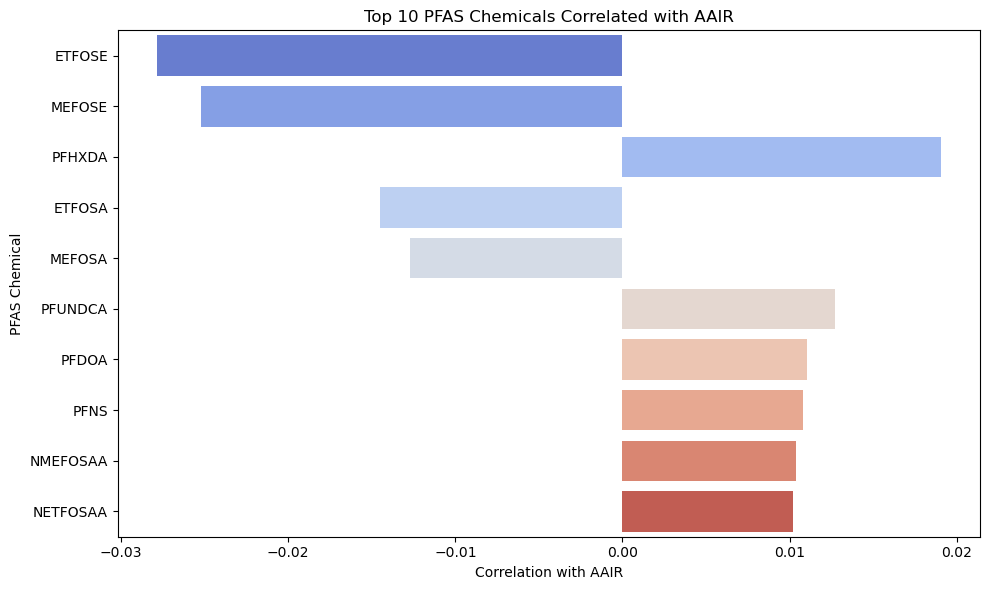

In [ ]:

# Sort the top 10 chemicals with actual (signed) correlations
top_10_corr = chemical_correlations.loc[top_10_chemicals.index]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=top_10_corr.index, palette='coolwarm')
plt.title("Top 10 PFAS Chemicals Correlated with AAIR")
plt.xlabel("Correlation with AAIR")
plt.ylabel("PFAS Chemical")
plt.tight_layout()
plt.show()
